In [129]:
import yfinance as yf
import numpy as np
import pandas as pd

In [130]:
quotes = yf.download(['^GSPC', '^BVSP', 'IRFM11.SA', 'IMAB11.SA', 'XFIX11.SA', 'XINA11.SA', 'EURP11.SA'],
                     start='2010-01-01', end='2024-09-20')
quotes = quotes['Adj Close'].dropna()

quotes.rename(columns={'^GSPC': 'S&P 500', 
                       '^BVSP': 'Ibovespa', 
                       'IRFM11.SA': 'Juro Nominal', 
                       'IMAB11.SA': 'Juro Real', 
                       'XFIX11.SA': 'Imóveis BR'}, inplace=True)
returns = np.log(quotes / quotes.shift(1)).dropna()

[*********************100%***********************]  7 of 7 completed


In [131]:
summary = returns.agg(
    ['mean', 'std', 'skew', 'kurtosis']
).round(4).T

summary['mean'] = summary['mean'] * 252
summary['std'] = summary['std'] * np.sqrt(252)

summary

,mean,std,skew,kurtosis
Ticker,,,,
EURP11.SA,0.0504,0.200019,0.3886,4.4999
Juro Real,0.0504,0.077785,-1.3370,14.4209
Juro Nominal,0.0756,0.060323,-0.5937,48.7054
Imóveis BR,0.0504,0.093660,0.5097,11.0779
XINA11.SA,-0.2016,0.300028,1.0136,9.4851
Ibovespa,0.0252,0.184144,-0.2437,1.4326
S&P 500,0.1260,0.173032,-0.3006,1.9170


In [132]:
from arch.univariate import ConstantMean, GARCH, SkewStudent

In [133]:
# fit garch for each asset
models = {}
residuals = pd.DataFrame()

for asset in returns.columns:
    model = ConstantMean(100 * returns[asset])
    model.volatility = GARCH(1, 0, 1)
    model.distribution = SkewStudent()

    models[asset] = model.fit(disp='off')
    residuals[asset] = models[asset].resid 

    print(asset)

    print(models[asset].summary())

EURP11.SA
                           Constant Mean - GARCH Model Results                           
Dep. Variable:                         EURP11.SA   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -1362.44
Distribution:      Standardized Skew Student's t   AIC:                           2736.87
Method:                       Maximum Likelihood   BIC:                           2765.57
                                                   No. Observations:                  883
Date:                           Wed, Sep 25 2024   Df Residuals:                      882
Time:                                   21:13:37   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
----------------------------

In [134]:
from copulae import GaussianCopula
# leidot wolf
from sklearn.covariance import LedoitWolf

copula = GaussianCopula(dim=residuals.shape[1])
copula.fit(residuals / 100)

cov_matrix = LedoitWolf().fit(residuals).covariance_
corr_matrix = cov_matrix / np.sqrt(np.outer(np.diag(cov_matrix), np.diag(cov_matrix)))

copula[:] = corr_matrix

copula.summary()

/home/leme/miniconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


        EURP11.SA   Juro Real  Juro Nominal  Imóveis BR   XINA11.SA  \
count  883.000000  883.000000    883.000000  883.000000  883.000000   
mean     0.500000    0.500000      0.500000    0.500000    0.500000   
std      0.288503    0.288510      0.288508    0.288158    0.288506   
min      0.001131    0.001131      0.001131    0.001131    0.001131   
25%      0.250566    0.250566      0.250566    0.250848    0.250566   
50%      0.490950    0.500000      0.500000    0.500000    0.499434   
75%      0.749434    0.749434      0.749434    0.749434    0.749434   
max      0.998869    0.998869      0.998869    0.998869    0.998869   

         Ibovespa     S&P 500  
count  883.000000  883.000000  
mean     0.500000    0.500000  
std      0.288512    0.288512  
min      0.001131    0.001131  
25%      0.250566    0.250566  
50%      0.500000    0.500000  
75%      0.749434    0.749434  
max      0.998869    0.998869  


1.000000,-0.137002,-0.139654,0.031220,0.409152,-0.094339,0.466584
-0.137002,1.000000,0.270816,0.079120,-0.102159,0.247456,0.044016
-0.139654,0.270816,1.000000,0.029085,-0.060131,0.250611,0.071974
0.031220,0.079120,0.029085,1.000000,0.005602,0.140232,0.095443
0.409152,-0.102159,-0.060131,0.005602,1.000000,0.047597,0.264419
-0.094339,0.247456,0.250611,0.140232,0.047597,1.000000,0.382804
0.466584,0.044016,0.071974,0.095443,0.264419,0.382804,1.000000


In [135]:
n_simulations = 10000
n_days = 252

simulated_resid = np.array(copula.random(n=n_simulations*n_days)).reshape(n_days, n_simulations, -1)
simulated_returns = pd.DataFrame()

for i, asset in enumerate(returns.columns):

    def scenario_rng(random):
        simulations, horizon = random

        sample = simulated_resid[:, :, i].reshape(n_simulations, n_days)[:simulations, :horizon]
        standard_sample = (sample - sample.mean(axis=0)) / sample.std(axis=0)

        return standard_sample
    
    simulated_returns[asset] = (models[asset].forecast(simulations=n_simulations,
                                                      horizon=n_days,
                                                      method='simulation',
                                                      reindex=False,
                                                      rng=scenario_rng).simulations.values[-1] / 100).sum(axis=1)

<Axes: >

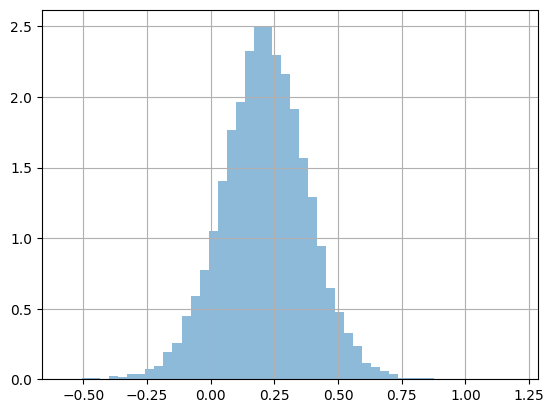

In [136]:
simulated_returns['S&P 500'].hist(bins=50, alpha=0.5, label='S&P 500', density=True)

In [137]:
simulated_returns.agg(
    ['mean', 'std', 'skew', 'kurtosis']
).round(4).T

,mean,std,skew,kurtosis
EURP11.SA,0.1248,0.1807,0.0373,0.1816
Juro Real,0.0590,0.0762,-0.0409,-0.0050
Juro Nominal,0.0783,0.0461,0.0244,0.1326
Imóveis BR,0.0236,0.2305,-1.1103,30.9999
XINA11.SA,-0.1734,0.2802,-0.0054,0.0250
Ibovespa,0.0542,0.1368,-0.0397,0.0366
S&P 500,0.2117,0.1674,-0.0271,0.4500


In [138]:
views = {
    # 'S&P 500': 0.15,
    'Ibovespa': 0.015,
    # 'Juro Real': 0.04
}

pd.Series(views)

Ibovespa    0.015
dtype: float64

In [139]:
p = np.ones(simulated_returns.shape[0]) / simulated_returns.shape[1]
p = p.reshape(-1, 1)

In [140]:
from opt_engine import *
from entropy_pooling import entropy_pooling

In [141]:
returns

Ticker,EURP11.SA,Juro Real,Juro Nominal,Imóveis BR,XINA11.SA,Ibovespa,S&P 500
Date,,,,,,,
2021-01-20 00:00:00+00:00,-0.010811,-0.001358,0.041801,0.000000,0.021142,-0.008029,0.013839
2021-01-21 00:00:00+00:00,0.021506,-0.004458,-0.044405,-0.000975,0.001672,-0.010624,0.000317
2021-01-22 00:00:00+00:00,0.012494,-0.002112,-0.000921,-0.002931,0.019032,-0.010789,-0.003015
2021-01-26 00:00:00+00:00,-0.031040,0.005581,0.001841,-0.000979,-0.009885,-0.006061,0.002119
2021-01-27 00:00:00+00:00,-0.005929,-0.003097,0.000153,-0.000980,-0.017537,-0.005010,-0.026013
...,...,...,...,...,...,...,...
2024-09-13 00:00:00+00:00,-0.003905,0.011358,0.002951,0.001681,-0.006908,0.006344,0.005393
2024-09-16 00:00:00+00:00,-0.003135,-0.006460,-0.004607,-0.001681,-0.008703,0.001748,0.001256
2024-09-17 00:00:00+00:00,-0.008672,-0.000299,0.000947,0.000000,0.006969,-0.001170,0.000265


In [142]:
def entropy_mix_q(returns, views, n_assets_per_loop = None):
    p = np.ones(returns.shape[0]) / returns.shape[1]
    p = p.reshape(-1, 1)

    if n_assets_per_loop is None:
        n_assets_per_loop = len(views)

    n_loops = len(views) // n_assets_per_loop + 1

    for i in range(n_loops):
        assets = list(views.keys())[:(n_assets_per_loop) * (i + 1)]
        view = np.array(list(views.values())[:(n_assets_per_loop) * (i + 1)])

        # Soma das probabilidades deve ser 1
        H = np.ones(shape=(1, returns.shape[0]))
        h = np.array([1])

        # Expectativa sobre a média
        H = np.vstack([H, returns[assets].T.to_numpy()])
        h = np.hstack([h, view])
        h = h.reshape(-1, 1)

        # q = entropy_mix_gd(
        #         p=p,
        #         constraints=MixtureRestrictions(
        #             h=h,
        #             H=H,
        #             f=np.array([]).reshape(0, returns.shape[1]),
        #             F=np.array([]).reshape(0)
        #         ),
        #         epochs=epochs,
        #         lr=lr
        # )

        q = entropy_pooling(
            p=p,
            A=H,
            b=h,
        )

        p = q

    n_effective_scenarios = np.exp(- q.T @ (np.log(q) - np.log(p))).squeeze()

    print(f'Effective number of scenarios: {n_effective_scenarios:.2f}')

    return q

In [143]:
simulated_returns.agg(
    ['mean', 'std', 'skew', 'kurtosis']
).round(4).T

,mean,std,skew,kurtosis
EURP11.SA,0.1248,0.1807,0.0373,0.1816
Juro Real,0.0590,0.0762,-0.0409,-0.0050
Juro Nominal,0.0783,0.0461,0.0244,0.1326
Imóveis BR,0.0236,0.2305,-1.1103,30.9999
XINA11.SA,-0.1734,0.2802,-0.0054,0.0250
Ibovespa,0.0542,0.1368,-0.0397,0.0366
S&P 500,0.2117,0.1674,-0.0271,0.4500


In [147]:
q = entropy_mix_q(returns=simulated_returns, views={
    'S&P 500': 0.15,
    'Ibovespa': 0.09,
    'Juro Real': 0.07,
    'Imóveis BR': 0.015,
    'Juro Nominal': 0.1,
    'XINA11.SA': -0.05,
    'EURP11.SA': 0.07
})



Effective number of scenarios: 1.00


array([[<Axes: title={'center': '0'}>]], dtype=object)

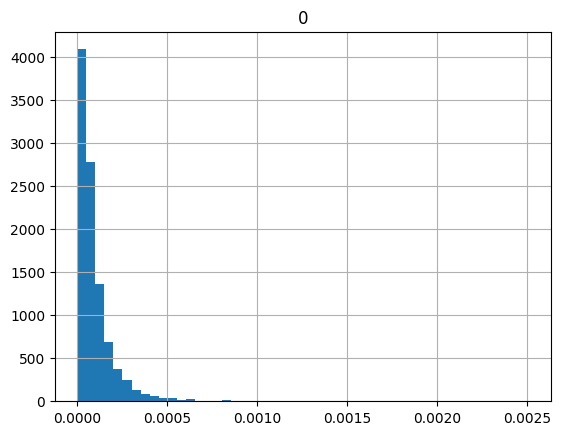

In [148]:
pd.DataFrame(q).hist(bins=50)

In [149]:
q.reshape(-1) @ simulated_returns

EURP11.SA       0.070
Juro Real       0.070
Juro Nominal    0.100
Imóveis BR      0.015
XINA11.SA      -0.050
Ibovespa        0.090
S&P 500         0.150
dtype: float64

In [160]:
i = 5550

print(simulated_returns.iloc[i])

print('Probabilidade: ', q[i][0] * 100)

EURP11.SA      -0.189785
Juro Real       0.159939
Juro Nominal    0.243183
Imóveis BR     -0.018484
XINA11.SA      -0.230876
Ibovespa        0.339787
S&P 500        -0.152063
Name: 5550, dtype: float64
Probabilidade:  0.25053795950055


In [159]:
np.argmax(q)

5550

In [174]:
simulated_returns[simulated_returns['S&P 500'] > 0]['Ibovespa'].mean() * 100

6.343922329769922

In [150]:
simulated_returns

,EURP11.SA,Juro Real,Juro Nominal,Imóveis BR,XINA11.SA,Ibovespa,S&P 500
0,0.285868,0.021702,0.111526,0.005763,0.352333,0.175918,0.249514
1,0.246344,-0.076169,0.120856,-0.211182,-0.122935,0.138455,0.522862
2,0.161694,0.191862,0.030536,0.018573,0.507583,0.040364,0.107266
3,0.059697,0.078969,0.067514,-0.015550,-0.148393,0.201290,0.031888
4,-0.024624,0.061206,0.102885,0.001925,-0.629731,-0.031253,0.212435
...,...,...,...,...,...,...,...
9995,0.275016,-0.012620,0.056782,-0.133952,0.171920,0.282468,0.385813
9996,-0.105718,-0.007025,0.077276,-0.214791,-0.494234,0.008859,0.057817
9997,0.086971,0.108059,0.026991,0.059039,-0.100660,0.006793,0.155752
9998,0.105347,0.109010,0.063684,0.146931,-0.099773,0.074474,0.247243
